In [1]:
%run setup.ipynb
%run peak-utils.ipynb 

In [2]:
signal_pops = [pop for pop in pop_defs if pop not in {'ke'}]
signal_pops

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ug_gam']

In [4]:
df_all = (
    pd.concat([
        pd.read_csv(here() / f'data/signals/signals_{pop}.csv', index_col=0)
        for pop in signal_pops
    ])
    .reset_index(drop=True)
)
df_all.head()

,pop,chromosome,gcenter,pcenter,delta_i,signal_max,locus,chromosome_arm,pcenter_arm,gpos_max,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
0,ao_col,2,16.650178,8325089,11047,0.149080,NaN,2R,8325089,16.660989,...,0.078028,0.459920,0.008111,0.462513,0.457341,0.017472,-91317.624459,-91281.693196,0.844366,-80269.789270
1,ao_col,2,27.576049,13788024,2736,0.062623,NaN,2R,13788024,27.534852,...,0.030000,0.333063,0.499994,0.471020,0.235512,0.015574,-96728.831869,-96693.015625,0.376405,-93991.970357
2,ao_col,2,49.334733,24667366,4253,0.067143,NaN,2R,24667366,49.323638,...,0.034753,0.236341,0.293226,0.289608,0.192872,0.015146,-54622.594829,-54589.821421,0.139484,-50368.831357
3,ao_col,2,56.109531,28054765,15492,0.438609,NaN,2R,28054765,56.104346,...,0.343092,0.131113,0.418403,0.175226,0.098106,0.019626,-77845.761700,-77810.132344,1.923372,-62353.498749
4,ao_col,2,68.794891,34397445,4042,0.123110,NaN,2R,34397445,68.805236,...,0.030001,1.643008,-0.500000,1.161782,2.323565,0.013836,-68475.781930,-68441.381088,0.523287,-64433.188896


In [5]:
sns.set_style('white')
sns.set_style('ticks')

In [6]:
def plot_signals(chromosome, ax=None, pad=1e6, height=.6, ylim=12):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(facecolor='w', figsize=(9 * chromosome_plen[chromosome] / chromosome_plen['2'], 3.5))
        sns.despine(ax=ax, left=True)
    ranks = [None] * 100
    max_rank = 0
    for _, signal in df_all.loc[df_all['chromosome'] == chromosome].sort_values('pcenter').iterrows():
        for rank, prev in enumerate(ranks):
            if prev is None or signal.span2_pstart > prev.span2_pstop + pad:
                color = pop_colors[signal['pop']]
                signal_width = signal.span2_pstop - signal.span2_pstart
    #             patch = mpl.patches.Rectangle(xy=(signal.span1_pstart, rank), width=signal_width, height=.7, 
    #                                           facecolor=color, alpha=.5, lw=2, edgecolor=color)
                patch = mpl.patches.Polygon(xy=[[signal.span2_pstart, rank+height/2], 
                                                [signal.pcenter, rank], 
                                                [signal.span2_pstop, rank+height/2],
                                                [signal.pcenter, rank+height]
                                               ],  
                                            facecolor=color, alpha=.9, lw=2, edgecolor=color)
                ax.add_patch(patch)
                line = mpl.lines.Line2D([signal.pcenter, signal.pcenter], [rank+.1, rank+height-.1], color=color, alpha=1, lw=2)
                ax.add_line(line)
                ranks[rank] = signal
                if rank > max_rank:
                    max_rank = rank
                break
    for gene in ir_genes:
        if gene.chromosome == chromosome:
            ax.axvline(gene.chromosome_center, color='gray', lw=.5, zorder=0, linestyle='--')
            ax.annotate(gene.Name, xy=(gene.chromosome_center, ylim), rotation=45, ha='left', 
                        xytext=(-3, 3), textcoords='offset points', fontstyle='italic', fontsize=8)
    for ln, (lc, lp) in novel_loci.items():
        if lc == chromosome:
            ax.axvline(lp, color='gray', lw=.5, zorder=0, linestyle='--')
            ax.annotate(ln, xy=(lp, ylim), rotation=0, ha='center', xytext=(0, 3), 
                        textcoords='offset points', fontsize=8)
    if ylim < max_rank + 1:
        raise Exception
    ax.set_xlim(0, chromosome_plen[chromosome])
    ax.set_ylim(-.5, ylim)
    ax.set_yticks([])
    xticks = np.arange(0, chromosome_plen[chromosome], 10e6)
    ax.set_xticks(xticks)
    minor_ticks = np.arange(0, chromosome_plen[chromosome], 1e6)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels((xticks / 1e6).astype(int))
    ax.set_xlabel(f'Chromosome {chromosome} position (Mbp)')
    if fig:
        fig.tight_layout();

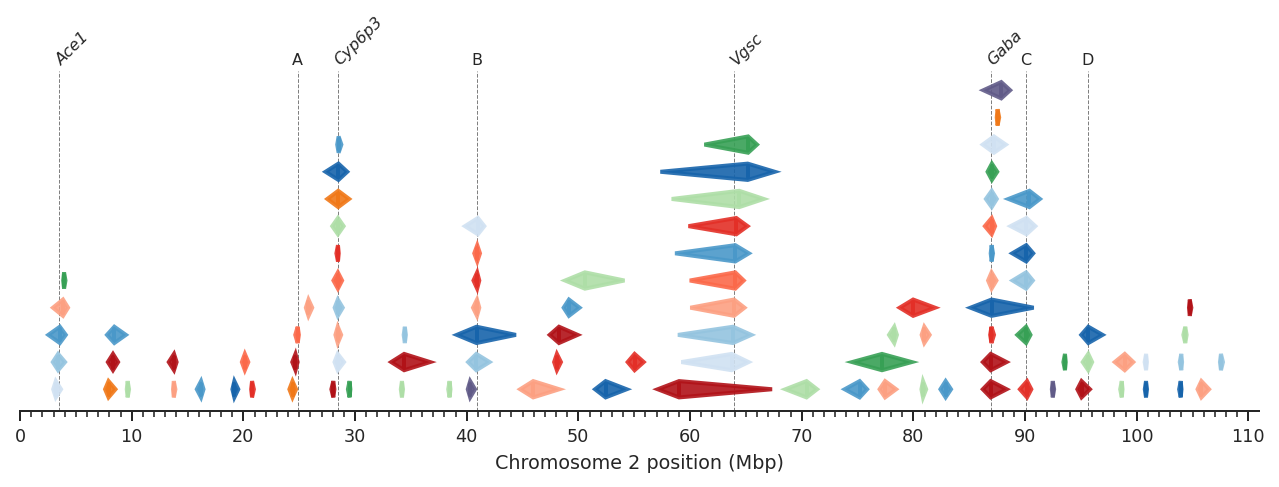

In [7]:
plot_signals('2')

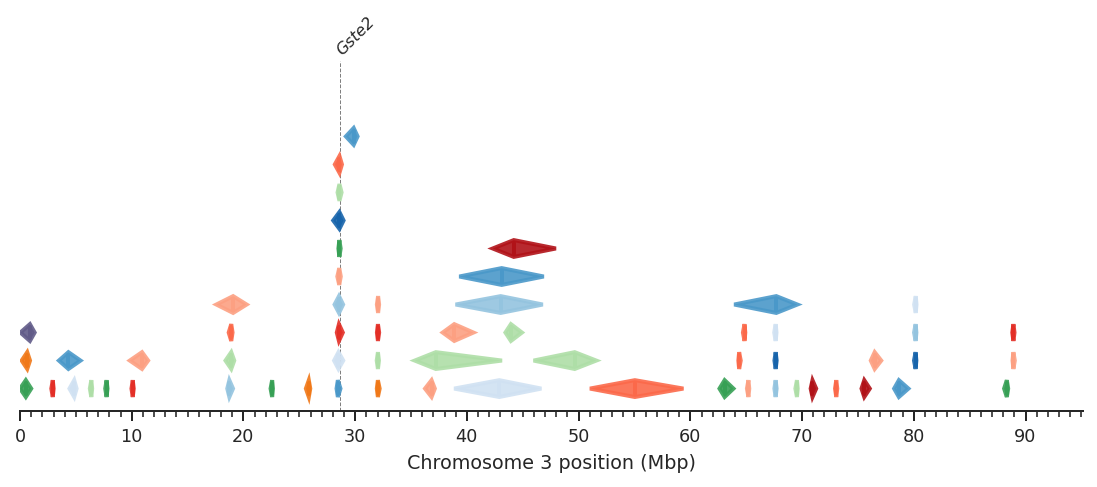

In [8]:
plot_signals('3')

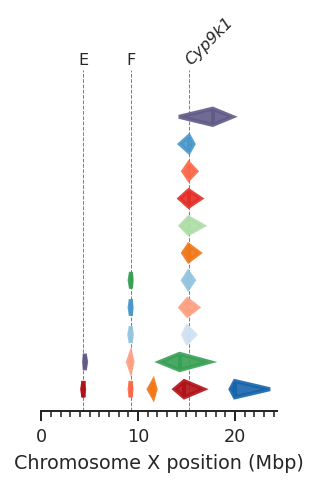

In [9]:
plot_signals('X')

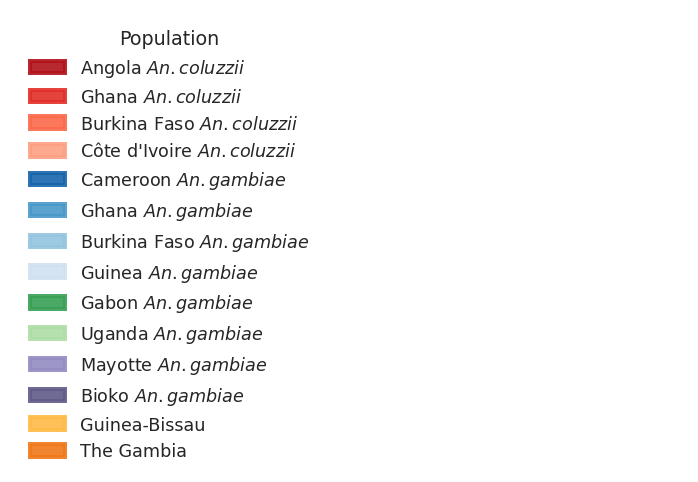

In [10]:
def plot_pop_legend(ax=None, ncol=1):
    if ax is None:
        fig, ax = plt.subplots(facecolor='w')
        sns.despine(ax=ax, left=True, bottom=True)
        ax.set_xticks([])
        ax.set_yticks([])
    handles = []
    for pop in pop_colors:
        if pop in signal_pops:
            patch = mpl.patches.Patch(color=pop_colors[pop], alpha=.9, lw=2, label=pop_labels[pop])
            handles.append(patch)
    ax.legend(handles=handles, ncol=ncol, title='Population', loc='upper left', frameon=False)
    
plot_pop_legend()

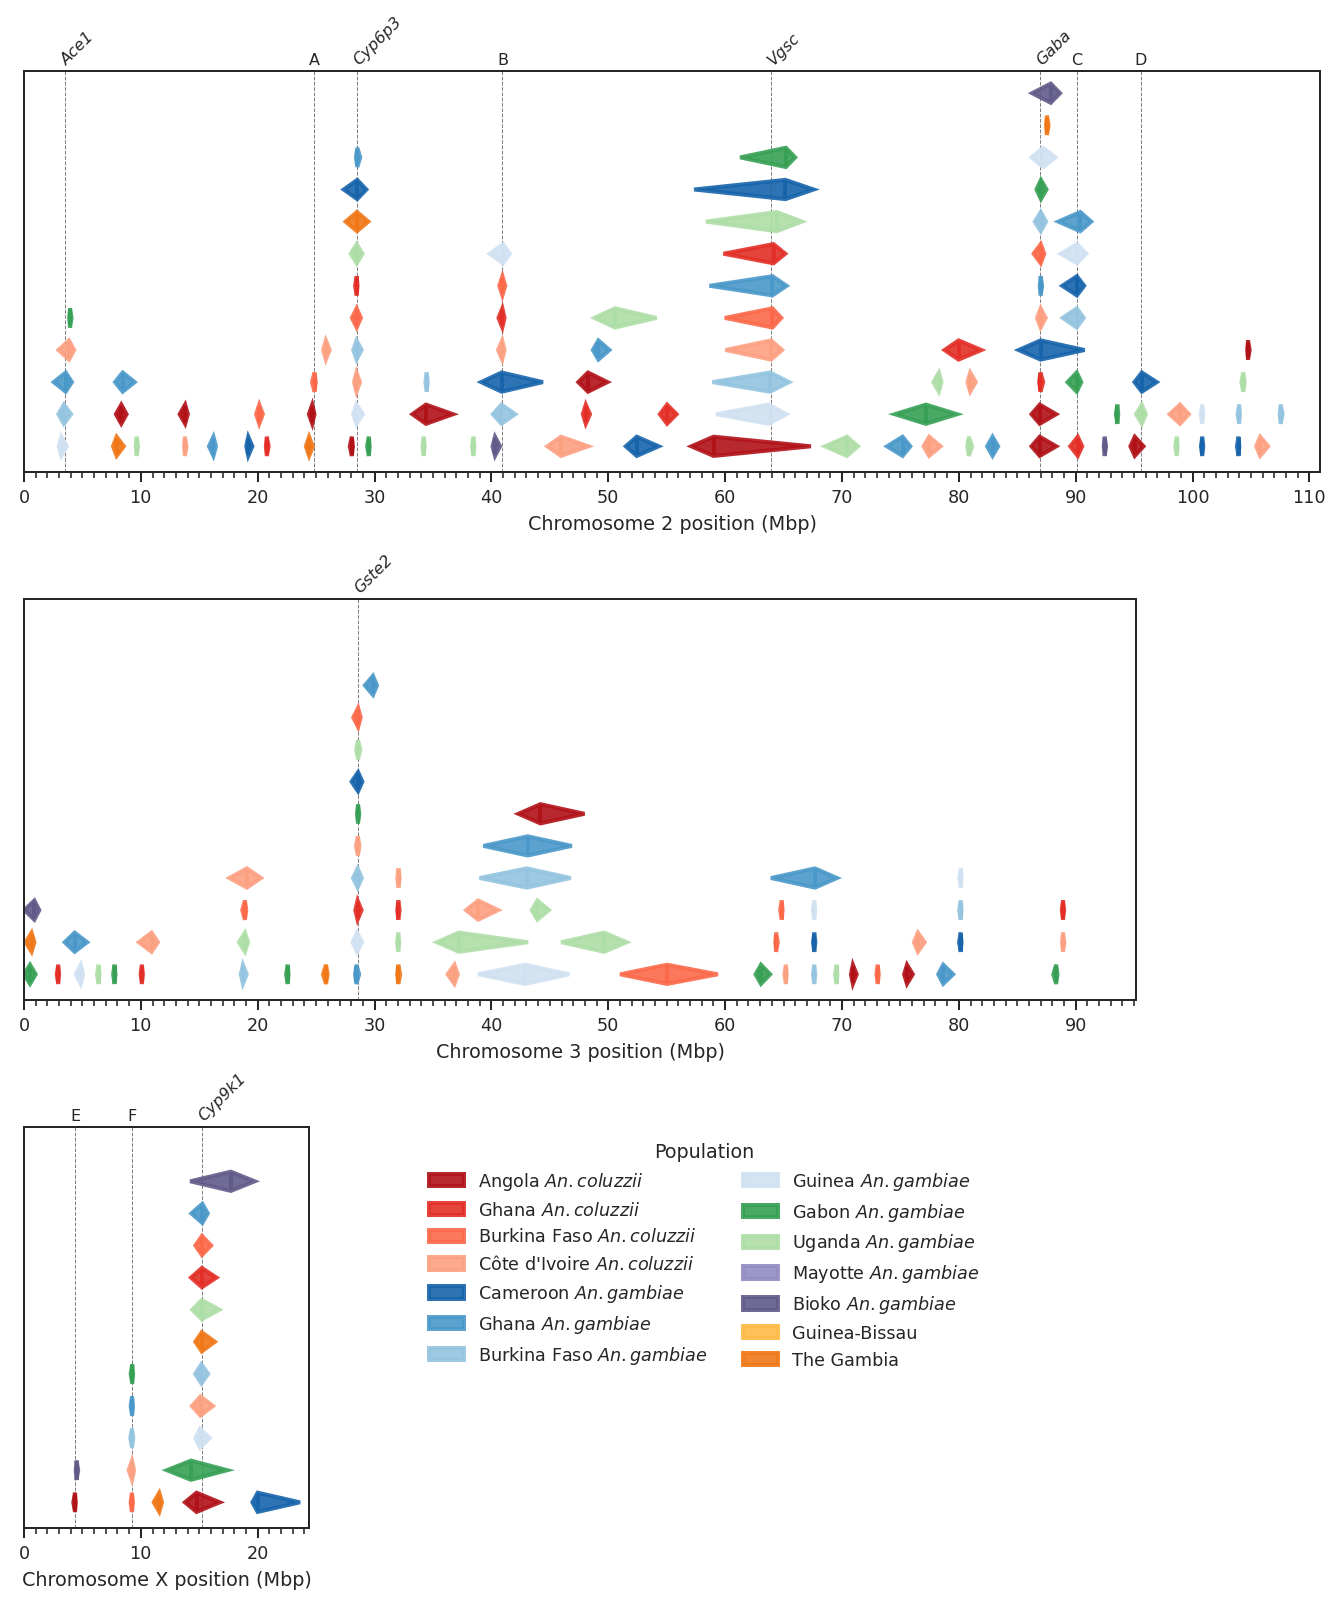

In [11]:
figw = 9
figh = 11
trackh = figh / 3
pad = .08
fig = plt.figure(figsize=(figw, figh))

ax = fig.add_axes([0, (2/3) + pad, (chromosome_plen['2'] / chromosome_plen['2']), 1/3 - pad])
# sns.despine(ax=ax, left=True)
plot_signals('2', ax=ax)

ax = fig.add_axes([0, 1/3 + pad, (chromosome_plen['3'] / chromosome_plen['2']), 1/3 - pad])
# sns.despine(ax=ax, left=True)
plot_signals('3', ax=ax)

ax = fig.add_axes([0, 0 + pad, (chromosome_plen['X'] / chromosome_plen['2']), 1/3 - pad])
# sns.despine(ax=ax, left=True)
plot_signals('X', ax=ax)

ax = fig.add_axes([(chromosome_plen['X'] / chromosome_plen['2']) + pad, 0 + pad, 2 * (chromosome_plen['X'] / chromosome_plen['2']), 1/3 - pad])
sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks([])
ax.set_yticks([])
plot_pop_legend(ax=ax, ncol=2)


In [12]:
df_all.query('pop == "bf_gam"').sort_values('delta_i', ascending=False)

,pop,chromosome,gcenter,pcenter,delta_i,signal_max,locus,chromosome_arm,pcenter_arm,gpos_max,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
40,bf_gam,3,57.100411,28550205,27841,0.378958,Gste2,3R,28550205,57.190436,...,0.331899,0.384005,0.056262,0.399276,0.369318,0.014507,-81029.815505,-80994.473925,0.761570,-53188.221312
45,bf_gam,X,30.354189,15177094,27194,0.377033,Cyp9k1,X,15177094,30.510182,...,0.389450,0.561161,-0.071776,0.533925,0.589785,0.011236,-75306.222553,-75271.217670,0.752231,-48111.326293
31,bf_gam,2,56.921921,28460960,25495,0.350839,Cyp6p3,2R,28460960,56.924900,...,0.271076,0.355811,-0.304802,0.288048,0.439515,0.010386,-86462.771008,-86427.142196,0.752237,-60967.770307
44,bf_gam,X,18.485669,9242834,15988,0.232123,F,X,9242834,18.473882,...,0.212058,0.128282,0.245964,0.152128,0.108174,0.011383,-89057.516218,-89021.763797,0.736630,-73069.259049
33,bf_gam,2,81.725239,40862619,15283,0.141245,B,2R,40862619,81.824712,...,0.104611,0.936580,-0.340054,0.739909,1.185527,0.015049,-67538.736722,-67504.522977,0.401322,-52255.650647
36,bf_gam,2,171.023349,90094355,14705,0.271562,C,2L,28549250,171.006034,...,0.229083,0.852647,0.500000,1.205825,0.602912,0.013206,-53764.692752,-53730.663628,2.111242,-39059.645304
34,bf_gam,2,120.399193,63844055,14600,0.957112,Vgsc,2L,2298950,120.447270,...,0.938727,1.259686,0.029220,1.285460,1.234429,0.033135,-31086.013954,-31053.531043,8.566555,-16485.574432
30,bf_gam,2,6.827076,3413537,7599,0.045310,Ace1,2R,3413537,6.805340,...,0.030000,0.544751,-0.187414,0.478388,0.620319,0.007571,-112966.524401,-112930.384973,0.153620,-105366.719764
38,bf_gam,2,205.919474,107542418,6531,0.040111,NaN,2L,45997313,205.922234,...,0.030000,0.126647,-0.499357,0.089593,0.179026,0.007738,-65423.828204,-65390.971692,0.021793,-58892.368348
39,bf_gam,3,37.470106,18735053,6383,0.022566,NaN,3R,18735053,37.313411,...,0.030000,0.248485,-0.411523,0.186818,0.330507,0.006171,-57200.144262,-57168.572551,0.003343,-50816.626579


In [14]:
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !jupyter labextension install @bokeh/jupyter_bokeh

In [93]:
import bokeh.plotting as bkp
import bokeh.models as bkm
import bokeh.layouts as bkl
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [31]:
x = [1, 2, 3, 4, 5, 12, 2, 2, 3]
y = [6, 7, 6, 4, 5, 15, 23, 45, 4]
p = bkp.figure(title="example", plot_width=300, plot_height=300)
p.line(x, y, line_width=2)
p.circle(x, y, size=10, fill_color="white")
bkp.show(p)

In [41]:
df_genes.reset_index().head()

,ID,seqid,source,type,start,end,score,strand,phase,Name,description,biotype,chromosome,chromosome_start,chromosome_end,chromosome_center
0,AGAP004677,2L,VectorBase,gene,157348,186936,-1,-,-1,.,methylenetetrahydrofolate dehydrogenase(NAD ) ...,protein_coding,2,61702453,61732041,61717247.0
1,AGAP004678,2L,VectorBase,gene,203779,205293,-1,+,-1,.,.,protein_coding,2,61748884,61750398,61749641.0
2,AGAP004679,2L,VectorBase,gene,207894,210460,-1,+,-1,.,Folylpolyglutamate synthase [Source:UniProtKB/...,protein_coding,2,61752999,61755565,61754282.0
3,AGAP004680,2L,VectorBase,gene,271285,271815,-1,+,-1,.,.,protein_coding,2,61816390,61816920,61816655.0
4,AGAP004681,2L,VectorBase,gene,358329,359280,-1,-,-1,.,.,protein_coding,2,61903434,61904385,61903909.5


In [33]:
vgsc

seqid                                                               2L
source                                                      VectorBase
type                                                              gene
start                                                          2358158
end                                                            2431617
score                                                               -1
strand                                                               +
phase                                                               -1
Name                                                              Vgsc
description          voltage-gated sodium channel [Source:VB Commun...
biotype                                                 protein_coding
chromosome                                                           2
chromosome_start                                              63903263
chromosome_end                                                63976722
chromo

In [156]:
def plot_genes(genes, chromosome, start=None, stop=None, fig=None, offset=0, x_range=None,
               plot_width=900, plot_height=100):

    # setup figure
    if start is None:
        start = 0
    if stop is None:
        stop = chromosome_plen[chromosome]
    if x_range is None:
        x_range = bkm.Range1d(start/1e6, stop/1e6, bounds=(start/1e6, stop/1e6))
    if fig is None:
        hover = bkm.HoverTool(
            tooltips="<p>@label<br/>@seqid:@start{,}-@end{,}</p>")
        fig = bkp.figure(title='Genes', plot_width=plot_width,
                         plot_height=plot_height, x_range=x_range,
                         tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,'
                               'reset,tap'.split() + [hover],
                         toolbar_location='above', active_drag='xpan',
                         active_scroll='xwheel_zoom')
        fig.xaxis.axis_label = f'Chromosome {chromosome} position (Mbp)'
#         url = '../../../../../gene/@id.html'
#         taptool = fig.select(type=bmod.TapTool)
#         taptool.callback = bmod.OpenURL(url=url)

    # filter to region
    df = genes[genes['chromosome'] == chromosome].reset_index()
        
    labels = [('{}'.format(gene['ID']) +
               (' ({})'.format(gene['Name']) if gene['Name'] != '.' else '') +
               (' - {}'.format(gene['description'].split('[Source:')[0])
                if gene['description'] != '.' else ''))
              for _, gene in df.iterrows()]
#     hover = bmod.HoverTool(tooltips=[
#         ("ID", '@id'),
#         ("Name", '@name'),
#         ("Description", '@description'),
#         ("Location", "@seqid:@start-@end"),
#     ])
    bottom = np.zeros(len(df))
    bottom[df.strand == '+'] = 1
    source = bkm.ColumnDataSource(data={
        'chromosome': df['chromosome'],
        'chromosome_start': df['chromosome_start'],
        'chromosome_end': df['chromosome_end'],
        'seqid': df['seqid'],
        'start': df['start'],
        'end': df['end'],
        'left': df['chromosome_start'] / 1e6,
        'right': df['chromosome_end'] / 1e6,
        'bottom': bottom,
        'top': bottom + .8,
        'id': df['ID'],
        'name': df['Name'],
        'description': df['description'],
        'label': labels,
    })
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=source, line_width=0)
    fig.y_range = bkm.Range1d(-.5, 2.3)
    yticks = [0.4, 1.4]
    yticklabels = ['reverse', 'forward']
    fig.yaxis.ticker = yticks
    fig.yaxis.major_label_overrides = {k: v for k, v in zip(yticks, yticklabels)}
    fig.ygrid.visible = False

    return fig


In [157]:
fig = plot_genes(df_genes, chromosome='2')
bkp.show(fig)

In [115]:
df_all.head()

,pop,chromosome,gcenter,pcenter,delta_i,signal_max,locus,chromosome_arm,pcenter_arm,gpos_max,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
0,ao_col,2,16.650178,8325089,11047,0.149080,NaN,2R,8325089,16.660989,...,0.078028,0.459920,0.008111,0.462513,0.457341,0.017472,-91317.624459,-91281.693196,0.844366,-80269.789270
1,ao_col,2,27.576049,13788024,2736,0.062623,NaN,2R,13788024,27.534852,...,0.030000,0.333063,0.499994,0.471020,0.235512,0.015574,-96728.831869,-96693.015625,0.376405,-93991.970357
2,ao_col,2,49.334733,24667366,4253,0.067143,NaN,2R,24667366,49.323638,...,0.034753,0.236341,0.293226,0.289608,0.192872,0.015146,-54622.594829,-54589.821421,0.139484,-50368.831357
3,ao_col,2,56.109531,28054765,15492,0.438609,NaN,2R,28054765,56.104346,...,0.343092,0.131113,0.418403,0.175226,0.098106,0.019626,-77845.761700,-77810.132344,1.923372,-62353.498749
4,ao_col,2,68.794891,34397445,4042,0.123110,NaN,2R,34397445,68.805236,...,0.030001,1.643008,-0.500000,1.161782,2.323565,0.013836,-68475.781930,-68441.381088,0.523287,-64433.188896


In [164]:
def plot_h12(pop, chromosome, start=None, stop=None, fig=None,
             plot_width=900, plot_height=200, x_range=None):
    
    if start is None:
        start = 0
    if stop is None:
        stop = chromosome_plen[chromosome]
    if x_range is None:
        x_range = bkm.Range1d(start/1e6, stop/1e6, bounds=(start/1e6, stop/1e6))
    
    # load gwss data
    pwindows, gwindows, _, h12, _, _ = load_h12_gwss(pop, chromosome)
    ppos = pwindows.mean(axis=1)
    gpos = gwindows.mean(axis=1)
    x = ppos / 1e6
    y = h12
    
    # subset to region
    loc_region = slice(bisect_left(ppos, start), bisect_right(ppos, stop))
    x = x[loc_region]
    y = y[loc_region]
    y_max = np.max(y)
#     y_range = bkm.Range1d(0, y_max*1.1, bounds=(0, 1))
    fig = bkp.figure(title=pop_labels[pop].replace('$', ''), plot_width=plot_width,
                     plot_height=plot_height,
                     tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset',
                     toolbar_location='above', active_drag='xpan',
                     active_scroll='xwheel_zoom', x_range=x_range)
    fig.circle(x, y, alpha=1)
    
    # plot fits
    df_pop = df_all[(df_all['pop'] == pop) & (df_all['chromosome'] == chromosome)]
    for _, signal in df_pop.iterrows():
        peak_span = bkm.BoxAnnotation(left=signal['span2_pstart']/1e6,
                                      right=signal['span2_pstop']/1e6,
                                      level='underlay',
                                      fill_color='red', fill_alpha=.2)
        focus_span = bkm.BoxAnnotation(left=signal['span1_pstart']/1e6,
                                       right=signal['span1_pstop']/1e6,
                                       level='underlay',
                                       fill_color='red', fill_alpha=.2)
        epicenter_span = bkm.BoxAnnotation(left=(signal['pcenter'] - 10000)/1e6,
                                           right=(signal['pcenter'] + 10000)/1e6,
                                           level='underlay', fill_color='red',
                                           fill_alpha=.8)
        fig.add_layout(peak_span)
        fig.add_layout(focus_span)
        fig.add_layout(epicenter_span)
    
    fig.yaxis.axis_label = 'H12'
    return fig


In [165]:
fig = plot_h12('bf_gam', '2', start=20_000_000, stop=30_000_000)
bkp.show(fig)

In [166]:
def fig_h12(pops, chromosome, start=None, stop=None):
    if isinstance(pops, str):
        pops = [pops]
    genes = plot_genes(df_genes, chromosome, start=start, stop=stop)
    tracks = [plot_h12(pop, chromosome, start=start, stop=stop, x_range=genes.x_range) for pop in pops]
    gfig = bkl.gridplot([[track] for track in tracks] + [[genes]], toolbar_location='above')
    return gfig
    

In [167]:
bkp.show(fig_h12(['bf_gam', 'gn_gam', 'ug_gam'], '2', 25e6, 30e6))